In [1]:
# Notebook para obtener los resultados que se describen en esta página en kaggle.
#
# https://www.kaggle.com/code/azizozmen/heart-failure-predict-8-classification-techniques
#
# En Anaconda Navigator instalar previamente, con el gestor de entornos, instalar los siguientes paquetes:
# matplotlib, seaborn, scikit-learn, 
# Tiene las modificaciones necesarias para poder instalar las bibliotecas faltantes usando pip3 y pip.
# En la celda 6 se indica el nombre del archivo a procesar, en este caso se toma como referencia el que puso Miguel en la
# carpeta compartida en OneDrive, y es el de kaggle que tiene 12 atributos, se contempla que está en el subdirectorio
# datasets, creado en el mismo nivel donde está almacenado este notebook.

!pip3 install --upgrade setuptools
!pip3 install pyforest xgboost cufflinks colorama
!pip3 install termcolor

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
import pyforest
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, StandardScaler, PowerTransformer, MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.model_selection import RepeatedStratifiedKFold, KFold, cross_val_predict, train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, Ridge,ElasticNet
from sklearn.metrics import plot_confusion_matrix, r2_score, mean_absolute_error, mean_squared_error, classification_report, confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import make_scorer, precision_score, precision_recall_curve, plot_precision_recall_curve, plot_roc_curve, roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostClassifier
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif, f_regression, mutual_info_regression
from xgboost import XGBRegressor, XGBClassifier
from xgboost import plot_importance
from sklearn.pipeline import Pipeline
from sklearn.tree import plot_tree
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('max_colwidth',200)

# pd.set_option('display.max_rows', 100) # if you wish to see more rows rather than default, just uncomment this line.
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import colorama
from colorama import Fore, Style  # makes strings colored
from termcolor import colored

/Users/giovanni/opt/anaconda3/envs/papercvd/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# Definición de parámetros para el procesamiento de los datos.
file_name = "south_africa_heart_disease.csv"     # Nombre del archivo, debe encontrarse en este mismo subdirectorio.
pred_column_name = "chd"                         # Nombre de la columna de predicción.
test_split_size = 0.20                           # Porcentaje para test - train (20% - 80%) = 0.20
random_state = 0                                 # Valor a usar para la semilla de los algoritmos.
cross_validate_size = 10                         # Valor de k a usar para el algoritmo k-cross-fold-validation.
threshold_skew_limit = 0.5                       # This is our threshold-limit to evaluate skewness. Overall below abs(1) seems acceptable for the linear models. 
threshold_kurtosis_limit = 7                     # This is our threshold-limit to evaluate skewness. Overall below abs(1) seems acceptable for the linear models.
knn_neighbors = 3                                # Número de vecinos a usar en algoritmo KNN.
ada_boosting_estimators = 50                     # Número de estimators a usar en AdaBoosting.
random_forest_estimators = 10                    # Número de estimators a usar en RandomForest.
svm_c_values = [0.1, 1, 10, 100, 1000]           # Valores a usar para el algoritmo SVM.
learning_rates = [0.05, 0.1, 0.15, 0.25, 0.5, 0.6, 0.75, 0.85, 1]

# Function for determining the number and percentages of missing values

def missing (data_frame):
    missing_number = data_frame.isnull().sum().sort_values(ascending=False)
    missing_percent = (data_frame.isnull().sum()/data_frame.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['missing_number', 'missing_Percent'])
    return missing_values


In [4]:
# Function for insighting summary information about the column

def first_looking(data_frame, column):
    print("column name    : ", column)
    print("----------------------------------------------------")
    print("per_of_nulls   : ", "%", round(data_frame[column].isnull().sum()/data_frame.shape[0]*100, 2))
    print("num_of_nulls   : ", data_frame[column].isnull().sum())
    print("num_of_uniques : ", data_frame[column].nunique())
    print(data_frame[column].value_counts(dropna = False))

In [5]:
# Function for examining scores

def train_val(y_train, y_train_pred, y_test, y_pred):
    scores = {
        "train_set": {"Accuracy" : accuracy_score(y_train, y_train_pred),
                      "Precision" : precision_score(y_train, y_train_pred),
                      "Recall" : recall_score(y_train, y_train_pred),                          
                      "f1" : f1_score(y_train, y_train_pred)},
    
        "test_set":  {"Accuracy" : accuracy_score(y_test, y_pred),
                      "Precision" : precision_score(y_test, y_pred),
                      "Recall" : recall_score(y_test, y_pred),                          
                      "f1" : f1_score(y_test, y_pred)}
    }
    
    return pd.DataFrame(scores)

In [6]:
df0 = pd.read_csv(file_name)
df = df0

In [7]:
# Desplegar los primeros registros así como los últimos.
df.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.000,5.730,23.110,Present,49,25.300,97.200,52,1
1,144,0.010,4.410,28.610,Absent,55,28.870,2.060,63,1
2,118,0.080,3.480,32.280,Present,52,29.140,3.810,46,0
3,170,7.500,6.410,38.030,Present,51,31.990,24.260,58,1
4,134,13.600,3.500,27.780,Present,60,25.990,57.340,49,1


In [8]:
df.tail()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
457,214,0.400,5.980,31.720,Absent,64,28.450,0.000,58,0
458,182,4.200,4.410,32.100,Absent,52,28.610,18.720,52,1
459,108,3.000,1.590,15.230,Absent,40,20.090,26.640,55,0
460,118,5.400,11.610,30.790,Absent,64,27.350,23.970,40,0
461,132,0.000,4.820,33.410,Present,62,14.700,0.000,46,1


In [9]:
# Obtener una muestra de 10 registros.
df.sample(10)

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
114,116,31.200,3.170,14.990,Absent,47,19.400,49.060,59,1
228,138,2.000,5.110,31.400,Present,49,27.250,2.060,64,1
190,142,0.000,3.720,25.680,Absent,48,24.370,5.250,40,1
106,108,1.500,4.330,24.990,Absent,66,22.290,21.600,61,1
247,158,4.000,4.180,28.610,Present,42,25.110,0.000,60,0
386,144,0.000,4.170,29.630,Present,52,21.830,0.000,59,0
13,132,0.000,1.870,17.210,Absent,49,23.630,0.970,15,0
433,120,0.000,2.460,13.390,Absent,47,22.010,0.510,18,0
194,138,0.050,2.790,10.350,Absent,46,21.620,0.000,18,0
323,140,8.600,3.900,32.160,Present,52,28.510,11.110,64,1


In [10]:
df.columns

Index(['sbp', 'tobacco', 'ldl', 'adiposity', 'famhist', 'typea', 'obesity',
       'alcohol', 'age', 'chd'],
      dtype='object')

In [11]:
print("There is", df.shape[0], "observation and", df.shape[1], "columns in the dataset")

There is 462 observation and 10 columns in the dataset


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sbp        462 non-null    int64  
 1   tobacco    462 non-null    float64
 2   ldl        462 non-null    float64
 3   adiposity  462 non-null    float64
 4   famhist    462 non-null    object 
 5   typea      462 non-null    int64  
 6   obesity    462 non-null    float64
 7   alcohol    462 non-null    float64
 8   age        462 non-null    int64  
 9   chd        462 non-null    int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 36.2+ KB


In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sbp,462.000,138.327,20.496,101.000,124.000,134.000,148.000,218.000
tobacco,462.000,3.636,4.593,0.000,0.053,2.000,5.500,31.200
ldl,462.000,4.740,2.071,0.980,3.282,4.340,5.790,15.330
adiposity,462.000,25.407,7.781,6.740,19.775,26.115,31.227,42.490
typea,462.000,53.104,9.818,13.000,47.000,53.000,60.000,78.000
obesity,462.000,26.044,4.214,14.700,22.985,25.805,28.497,46.580
alcohol,462.000,17.044,24.481,0.000,0.510,7.510,23.892,147.190
age,462.000,42.816,14.609,15.000,31.000,45.000,55.000,64.000
chd,462.000,0.346,0.476,0.000,0.000,0.000,1.000,1.000


In [14]:
try:
  df.describe(include=object).T
except:
  print("The dataset does not contain categorical columns")

In [15]:
df.nunique()

sbp           62
tobacco      214
ldl          329
adiposity    408
famhist        2
typea         54
obesity      400
alcohol      249
age           49
chd            2
dtype: int64

In [16]:
# to find how many unique values object features have

for column in df.select_dtypes(include=[np.number]).columns:
  print(f"{column} has {df[column].nunique()} unique value")

sbp has 62 unique value
tobacco has 214 unique value
ldl has 329 unique value
adiposity has 408 unique value
typea has 54 unique value
obesity has 400 unique value
alcohol has 249 unique value
age has 49 unique value
chd has 2 unique value


In [17]:
df.duplicated().value_counts()

False    462
dtype: int64

In [18]:
missing (df)

,missing_number,missing_Percent
sbp,0,0.000
tobacco,0,0.000
ldl,0,0.000
adiposity,0,0.000
famhist,0,0.000
typea,0,0.000
obesity,0,0.000
alcohol,0,0.000
age,0,0.000
chd,0,0.000


In [19]:
first_looking(df, pred_column_name)

column name    :  chd
----------------------------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
0    302
1    160
Name: chd, dtype: int64


0    302
1    160
Name: chd, dtype: int64


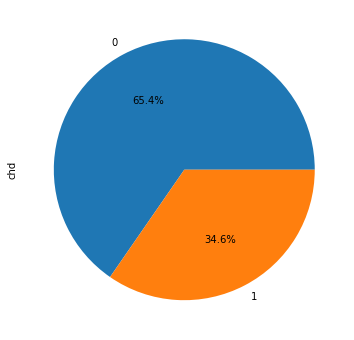

In [20]:
print(df[pred_column_name].value_counts())
df[pred_column_name].value_counts().plot(kind="pie", autopct='%1.1f%%', figsize=(6,6));

In [21]:
y = df[pred_column_name]
print(f'Percentage of Heart Disease: % {round(y.value_counts(normalize=True)[1]*100,2)} --> \
({y.value_counts()[1]} cases for Heart Disease)\nPercentage of NOT Heart Disease: % {round(y.value_counts(normalize=True)[0]*100,2)} --> ({y.value_counts()[0]} cases for NOT Heart Disease)')

Percentage of Heart Disease: % 34.63 --> (160 cases for Heart Disease)
Percentage of NOT Heart Disease: % 65.37 --> (302 cases for NOT Heart Disease)


In [22]:
df[pred_column_name].describe()

count   462.000
mean      0.346
std       0.476
min       0.000
25%       0.000
50%       0.000
75%       1.000
max       1.000
Name: chd, dtype: float64

In [23]:
df[df[pred_column_name]==0].describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='RdPu')

,count,mean,std,min,25%,50%,75%,max
sbp,302.000000,135.460265,17.984953,101.000000,124.000000,132.000000,144.000000,214.000000
tobacco,302.000000,2.634735,3.612095,0.000000,0.000000,1.035000,4.200000,20.000000
ldl,302.000000,4.344238,1.870444,0.980000,3.057500,3.980000,5.287500,15.330000
adiposity,302.000000,23.969106,7.772876,6.740000,17.510000,24.625000,29.957500,42.060000
typea,302.000000,52.367550,9.517636,13.000000,47.000000,52.500000,59.000000,77.000000
obesity,302.000000,25.737450,4.090741,17.750000,22.602500,25.570000,28.065000,46.580000
alcohol,302.000000,15.931358,23.499535,0.000000,0.510000,6.045000,22.422500,145.290000
age,302.000000,38.854305,14.882663,15.000000,27.000000,40.000000,50.750000,64.000000
chd,302.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [24]:
df[df[pred_column_name]==1].describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='RdPu')

,count,mean,std,min,25%,50%,75%,max
sbp,160.000000,143.737500,23.677468,102.000000,127.500000,138.000000,158.500000,218.000000
tobacco,160.000000,5.524875,5.565143,0.000000,1.500000,4.130000,8.200000,31.200000
ldl,160.000000,5.487938,2.225073,1.550000,3.940000,5.065000,6.582500,14.160000
adiposity,160.000000,28.120250,7.057996,9.390000,23.462500,28.405000,33.587500,42.490000
typea,160.000000,54.493750,10.246642,20.000000,47.750000,55.000000,61.000000,78.000000
obesity,160.000000,26.622937,4.391323,14.700000,23.635000,26.475000,28.780000,45.720000
alcohol,160.000000,19.145250,26.181102,0.000000,0.475000,8.330000,24.582500,147.190000
age,160.000000,50.293750,10.649119,17.000000,42.750000,53.000000,59.000000,64.000000
chd,160.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
print( f"Skewness: {df[pred_column_name].skew()}")

Skewness: 0.6480947454866691


In [26]:
print( f"Kurtosis: {df[pred_column_name].kurtosis()}")

Kurtosis: -1.5868615771243706


In [27]:
df[pred_column_name].iplot(kind='hist')

In [28]:
numerical= df.drop([pred_column_name], axis=1).select_dtypes('number').columns

categorical = df.select_dtypes('object').columns

print(f'Numerical Columns:  {df[numerical].columns}')
print('\n')
print(f'Categorical Columns: {df[categorical].columns}')

Numerical Columns:  Index(['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol',
       'age'],
      dtype='object')


Categorical Columns: Index(['famhist'], dtype='object')


In [29]:
df[numerical].head().T

,0,1,2,3,4
sbp,160.000,144.000,118.000,170.000,134.000
tobacco,12.000,0.010,0.080,7.500,13.600
ldl,5.730,4.410,3.480,6.410,3.500
adiposity,23.110,28.610,32.280,38.030,27.780
typea,49.000,55.000,52.000,51.000,60.000
obesity,25.300,28.870,29.140,31.990,25.990
alcohol,97.200,2.060,3.810,24.260,57.340
age,52.000,63.000,46.000,58.000,49.000


In [30]:
df[numerical].describe().T

,count,mean,std,min,25%,50%,75%,max
sbp,462.000,138.327,20.496,101.000,124.000,134.000,148.000,218.000
tobacco,462.000,3.636,4.593,0.000,0.053,2.000,5.500,31.200
ldl,462.000,4.740,2.071,0.980,3.282,4.340,5.790,15.330
adiposity,462.000,25.407,7.781,6.740,19.775,26.115,31.227,42.490
typea,462.000,53.104,9.818,13.000,47.000,53.000,60.000,78.000
obesity,462.000,26.044,4.214,14.700,22.985,25.805,28.497,46.580
alcohol,462.000,17.044,24.481,0.000,0.510,7.510,23.892,147.190
age,462.000,42.816,14.609,15.000,31.000,45.000,55.000,64.000


In [31]:
df[numerical].describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='RdPu')

,count,mean,std,min,25%,50%,75%,max
sbp,462.000000,138.326840,20.496317,101.000000,124.000000,134.000000,148.000000,218.000000
tobacco,462.000000,3.635649,4.593024,0.000000,0.052500,2.000000,5.500000,31.200000
ldl,462.000000,4.740325,2.070909,0.980000,3.282500,4.340000,5.790000,15.330000
adiposity,462.000000,25.406732,7.780699,6.740000,19.775000,26.115000,31.227500,42.490000
typea,462.000000,53.103896,9.817534,13.000000,47.000000,53.000000,60.000000,78.000000
obesity,462.000000,26.044113,4.213680,14.700000,22.985000,25.805000,28.497500,46.580000
alcohol,462.000000,17.044394,24.481059,0.000000,0.510000,7.510000,23.892500,147.190000
age,462.000000,42.816017,14.608956,15.000000,31.000000,45.000000,55.000000,64.000000


In [32]:
df[numerical].iplot(kind='hist');

In [33]:
df[numerical].iplot(kind='histogram', subplots=True,bins=50)

In [34]:
for i in numerical:
    df[i].iplot(kind="box", title=i, boxpoints="all", color='lightseagreen')

Numero de atributos: 8


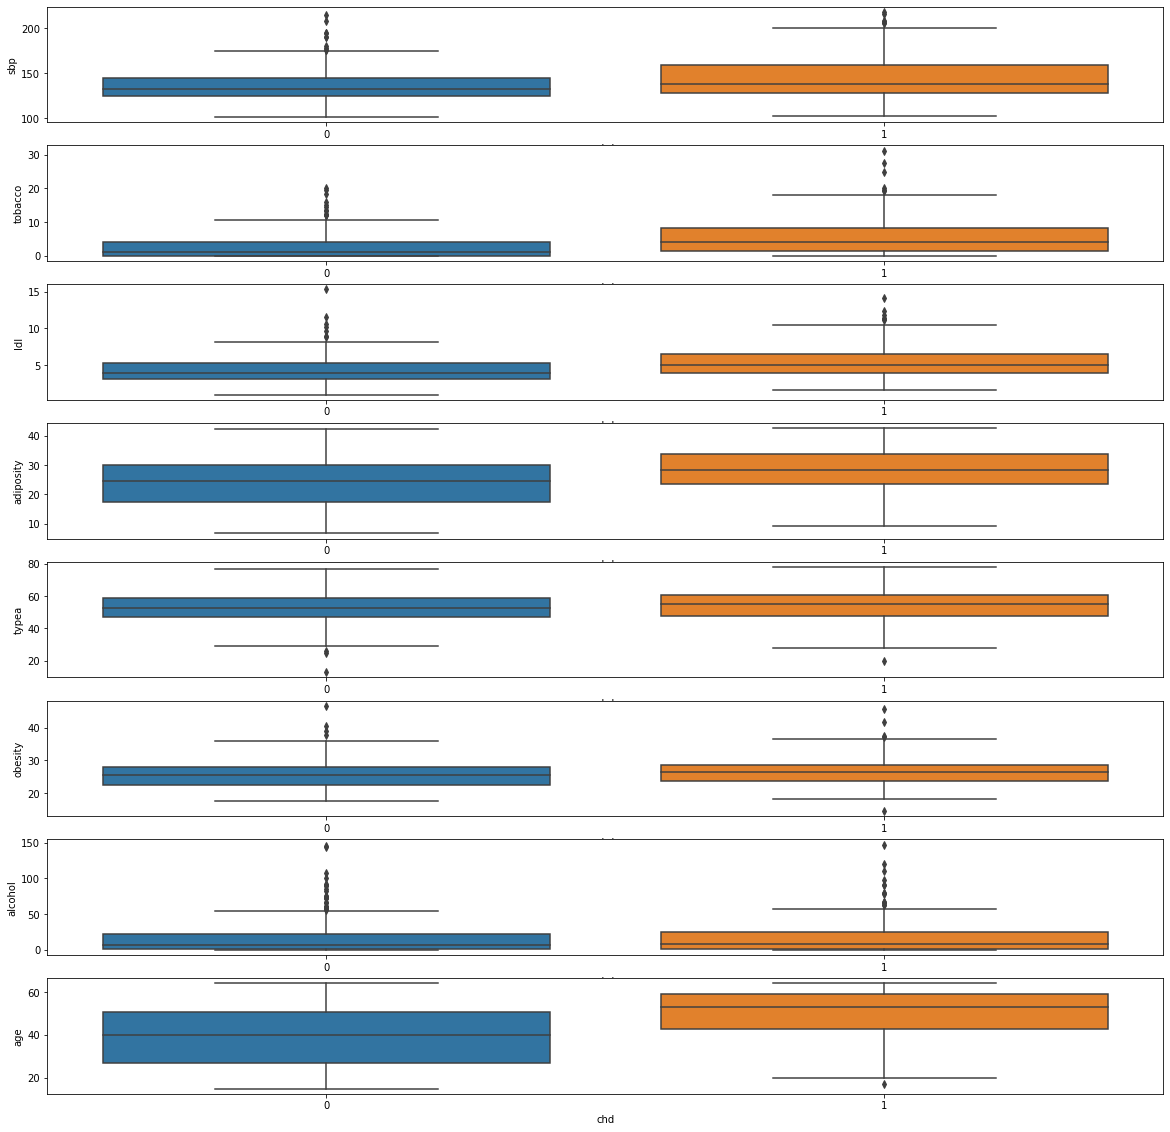

In [35]:
index = 0
figs_per_row = 1
print("Numero de atributos:", numerical.size)
plt.figure(figsize=(20,20))
for feature in numerical:
    if feature != pred_column_name:
        index += 1
        plt.subplot(numerical.size // figs_per_row, figs_per_row, index)
        sns.boxplot(x=pred_column_name, y=feature, data=df)

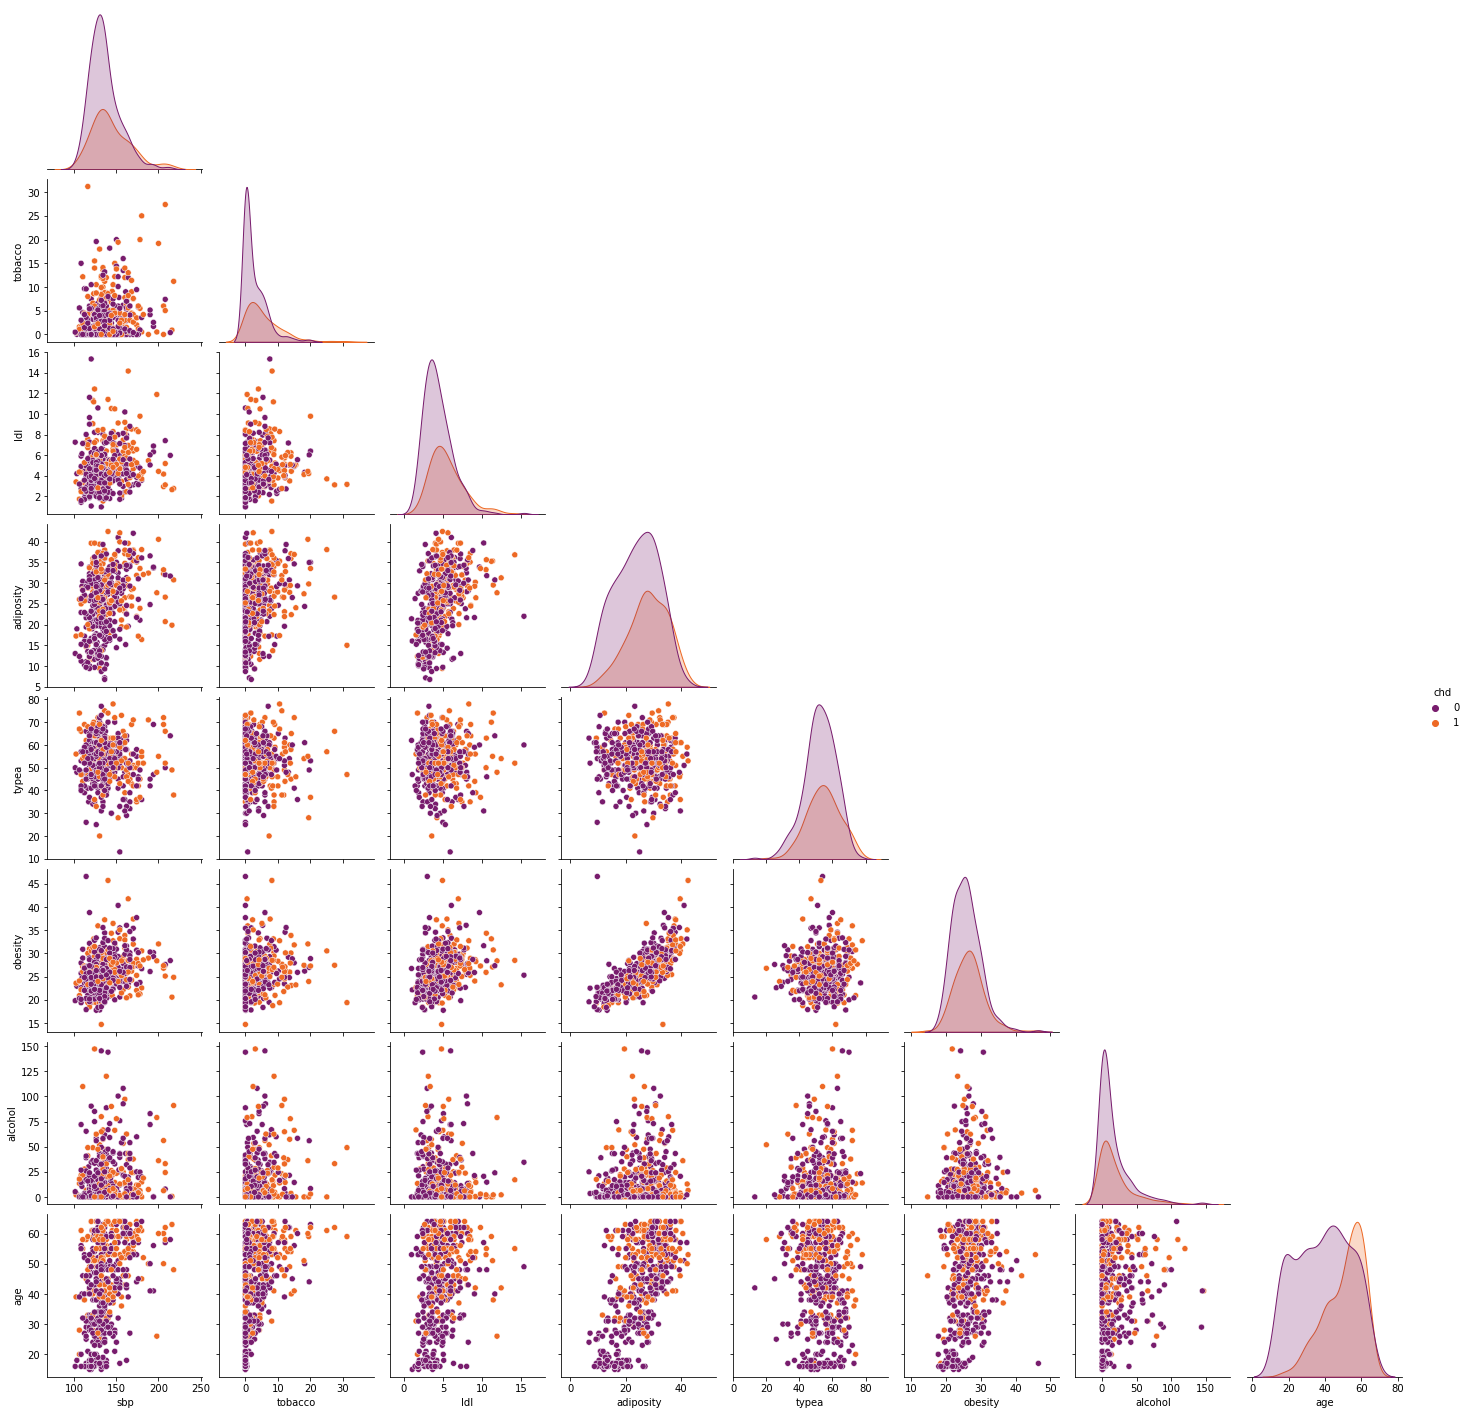

In [36]:
sns.pairplot(df, hue=pred_column_name, palette="inferno", corner=True);

In [37]:
skew_vals = df.skew().sort_values(ascending=False)
skew_vals

alcohol      2.313
tobacco      2.079
ldl          1.313
sbp          1.181
obesity      0.905
chd          0.648
adiposity   -0.215
typea       -0.346
age         -0.382
dtype: float64

In [38]:
# This is our threshold-limit to evaluate skewness. Overall below abs(1) seems acceptable for the linear models. 
skew_limit = threshold_skew_limit
skew_vals = df.skew()
skew_cols = skew_vals[abs(skew_vals)> skew_limit].sort_values(ascending=False)
skew_cols 

alcohol   2.313
tobacco   2.079
ldl       1.313
sbp       1.181
obesity   0.905
chd       0.648
dtype: float64

In [39]:
#Interpreting Skewness 

for skew in skew_vals:
    if -threshold_skew_limit < skew < threshold_skew_limit:
        print ("A skewness value of", '\033[1m', Fore.GREEN, skew, '\033[0m', "means that the distribution is approx.", '\033[1m', Fore.GREEN, "symmetric", '\033[0m')
    elif  -threshold_skew_limit < skew < -1.0 or threshold_skew_limit < skew < 1.0:
        print ("A skewness value of", '\033[1m', Fore.YELLOW, skew, '\033[0m', "means that the distribution is approx.", '\033[1m', Fore.YELLOW, "moderately skewed", '\033[0m')
    else:
        print ("A skewness value of", '\033[1m', Fore.RED, skew, '\033[0m', "means that the distribution is approx.", '\033[1m', Fore.RED, "highly skewed", '\033[0m')

A skewness value of   1.1805906253694305  means that the distribution is approx.   highly skewed 
A skewness value of   2.0792096673876146  means that the distribution is approx.   highly skewed 
A skewness value of   1.3131039798013922  means that the distribution is approx.   highly skewed 
A skewness value of   -0.21464592856083986  means that the distribution is approx.   symmetric 
A skewness value of   -0.34643775469900984  means that the distribution is approx.   symmetric 
A skewness value of   0.9052194041401875  means that the distribution is approx.   moderately skewed 
A skewness value of   2.3126989374804183  means that the distribution is approx.   highly skewed 
A skewness value of   -0.38173425852590315  means that the distribution is approx.   symmetric 
A skewness value of   0.6480947454866691  means that the distribution is approx.   moderately skewed 


In [40]:
kurtosis_vals = df.kurtosis().sort_values(ascending=False)
kurtosis_vals

alcohol      6.421
tobacco      5.968
ldl          2.877
obesity      2.256
sbp          1.782
typea        0.470
adiposity   -0.698
age         -1.016
chd         -1.587
dtype: float64

In [41]:
#Calculating Kurtosis 

# This is our threshold-limit to evaluate skewness. Overall below abs(1) seems acceptable for the linear models.
kurtosis_limit = threshold_kurtosis_limit 
kurtosis_vals = df.kurtosis()
kurtosis_cols = kurtosis_vals[abs(kurtosis_vals) > kurtosis_limit].sort_values(ascending=False)
kurtosis_cols

Series([], dtype: float64)

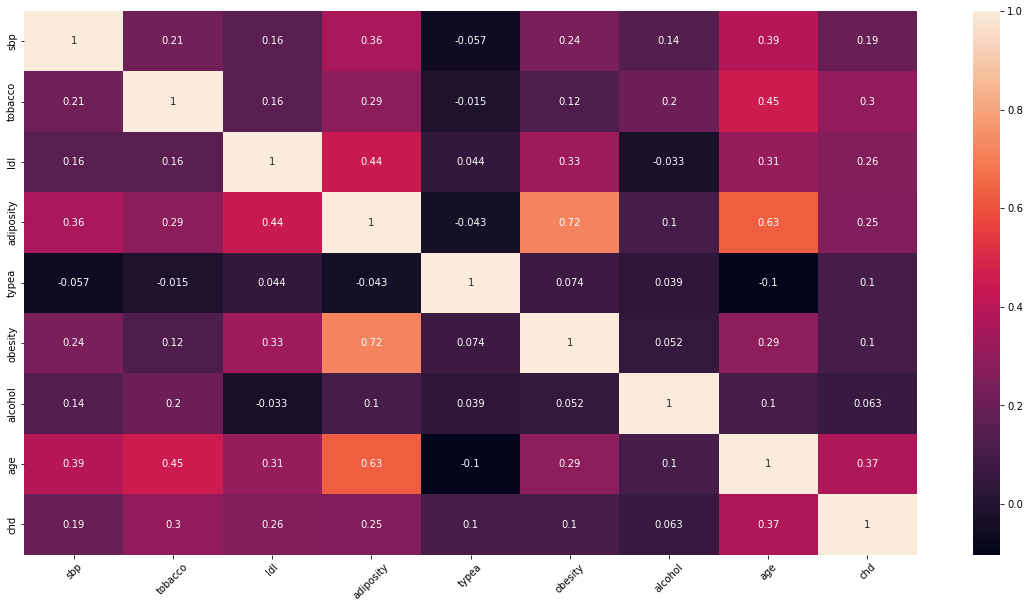

In [42]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(), annot=True)
plt.xticks(rotation=45);

In [43]:
df_temp = df.corr()

count = "Done"
feature =[]
collinear=[]
for col in df_temp.columns:
    for i in df_temp.index:
        if (df_temp[col][i]> .9 and df_temp[col][i] < 1) or (df_temp[col][i]< -.9 and df_temp[col][i] > -1) :
                feature.append(col)
                collinear.append(i)
                print(Fore.RED + f"\033[1mmulticolinearity alert in between\033[0m {col} - {i}")
        else:
            print(f"For {col} and {i}, there is NO multicollinearity problem") 

print("\033[1mThe number of strong corelated features:\033[0m", count) 

For sbp and sbp, there is NO multicollinearity problem
For sbp and tobacco, there is NO multicollinearity problem
For sbp and ldl, there is NO multicollinearity problem
For sbp and adiposity, there is NO multicollinearity problem
For sbp and typea, there is NO multicollinearity problem
For sbp and obesity, there is NO multicollinearity problem
For sbp and alcohol, there is NO multicollinearity problem
For sbp and age, there is NO multicollinearity problem
For sbp and chd, there is NO multicollinearity problem
For tobacco and sbp, there is NO multicollinearity problem
For tobacco and tobacco, there is NO multicollinearity problem
For tobacco and ldl, there is NO multicollinearity problem
For tobacco and adiposity, there is NO multicollinearity problem
For tobacco and typea, there is NO multicollinearity problem
For tobacco and obesity, there is NO multicollinearity problem
For tobacco and alcohol, there is NO multicollinearity problem
For tobacco and age, there is NO multicollinearity p

In [44]:
if (categorical.size != 0):
  df[categorical].head().T
  # categorical_count = df[categorical].head().count


In [45]:
print("Number of categorical attrib: ", categorical.shape[0])
categorical_count = categorical.shape[0]

Number of categorical attrib:  1


In [46]:
if (categorical.size != 0):
  # Remove categorical columns, replace using dummies variables.
  df = pd.get_dummies(df, drop_first=True)

In [47]:
X = df.drop([pred_column_name], axis=1)
y = df[pred_column_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split_size, stratify = y, random_state = random_state)
missing(df)

,missing_number,missing_Percent
sbp,0,0.000
tobacco,0,0.000
ldl,0,0.000
adiposity,0,0.000
typea,0,0.000
obesity,0,0.000
alcohol,0,0.000
age,0,0.000
chd,0,0.000
famhist_Present,0,0.000


In [48]:
scaler = MinMaxScaler()
scaler

MinMaxScaler()

In [49]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("X_train_scaled size:", X_train_scaled.shape)
print("X_test_scaled size:", X_test_scaled.shape)


X_train_scaled size: (369, 9)
X_test_scaled size: (93, 9)


In [50]:
# General Insights

def model_first_insight(X_train, y_train, class_weight, solver='liblinear'):
    # Logistic Regression
    log = LogisticRegression(random_state=random_state, class_weight=class_weight)
    log.fit(X_train, y_train)
    
    # Decision Tree
    decision_tree = DecisionTreeClassifier(criterion = 'entropy', random_state=101, class_weight=class_weight)
    decision_tree.fit(X_train, y_train)
   
    # Random Forest
    random_forest = RandomForestClassifier(n_estimators=10, criterion = 'entropy', random_state=random_state, class_weight=class_weight)
    random_forest.fit(X_train, y_train)
    
    # KNN
    knn = KNeighborsClassifier(n_neighbors = knn_neighbors)
    knn.fit(X_train, y_train) 
   
    # SVC
    svc = SVC(random_state=random_state, class_weight=class_weight)
    svc.fit(X_train, y_train) 
    
    # XGB
    xgb = XGBClassifier(random_state=random_state, class_weight=class_weight)
    xgb.fit(X_train, y_train)
    
    # AdaBoosting
    ab = AdaBoostClassifier(n_estimators=ada_boosting_estimators, random_state=random_state)
    ab.fit(X_train, y_train)
    
    # GB GradientBoosting
    gb = GradientBoostingClassifier(random_state=random_state)
    gb.fit(X_train, y_train)
    
    # Model Accuracy on Training Data
    print(f"\033[1m1) Logistic Regression Training Accuracy:\033[0m {log.score(X_train, y_train)}")
    print(f"\033[1m2) SVC Training Accuracy:\033[0m {svc.score(X_train, y_train)}")    
    print(f"\033[1m3) Decision Tree Training Accuracy:\033[0m {decision_tree.score(X_train, y_train)}")
    print(f"\033[1m4) Random Forest Training Accuracy:\033[0m {random_forest.score(X_train, y_train)}")
    print(f"\033[1m5) KNN Training Accuracy:\033[0m {knn.score(X_train, y_train)}")
    print(f"\033[1m6) GradiendBoosting Training Accuracy:\033[0m {gb.score(X_train, y_train)}")
    print(f"\033[1m7) AdaBoosting Training Accuracy:\033[0m {ab.score(X_train, y_train)}")
    print(f"\033[1m8) XGBoosting Training Accuracy:\033[0m {xgb.score(X_train, y_train)}")
    
    return log, svc, decision_tree, random_forest, knn, gb, ab, xgb

In [51]:
def models(X_train, y_train, class_weight):
    # Logistic Regression
    log = LogisticRegression(random_state=random_state, class_weight=class_weight, solver='liblinear')
    log.fit(X_train, y_train)
    
    # Decision Tree
    decision_tree = DecisionTreeClassifier(criterion = 'entropy', random_state=random_state, class_weight=class_weight)
    decision_tree.fit(X_train, y_train)
    
    # Random Forest
    random_forest = RandomForestClassifier(n_estimators=random_forest_estimators, criterion = 'entropy', random_state=random_state, class_weight=class_weight)
    random_forest.fit(X_train, y_train)
    # KNN
    knn = KNeighborsClassifier(n_neighbors = knn_neighbors)
    knn.fit(X_train, y_train) 
   
    # SVC
    svc = SVC(random_state=random_state, class_weight=class_weight)
    svc.fit(X_train, y_train) 
    
    # XGB
    xgb = XGBClassifier(random_state=random_state, class_weight=class_weight)
    xgb.fit(X_train, y_train)
    
    # AdaBoosting
    ab = AdaBoostClassifier(n_estimators=ada_boosting_estimators, random_state=random_state)
    ab.fit(X_train, y_train)
    
    # GB GradientBoosting
    gb = GradientBoostingClassifier(random_state=random_state)
    gb.fit(X_train, y_train)
    
    # Model Accuracy on Training Data
    print(f"\033[1m1) Logistic Regression Training Accuracy:\033[0m {log}")
    print(f"\033[1m2) SVC Training Accuracy:\033[0m {svc}")    
    print(f"\033[1m3) Decision Tree Training Accuracy:\033[0m {decision_tree}")
    print(f"\033[1m4) Random Forest Training Accuracy:\033[0m {random_forest}")
    print(f"\033[1m5) KNN Training Accuracy:\033[0m {knn}")
    print(f"\033[1m6) GradiendBoosting Training Accuracy:\033[0m {gb}")
    print(f"\033[1m7) AdaBoosting Training Accuracy:\033[0m {ab}")
    print(f"\033[1m8) XGBoosting Training Accuracy:\033[0m {xgb}")
  
    return log.score(X_train, y_train), svc.score(X_train, y_train),decision_tree.score(X_train, y_train),random_forest.score(X_train, y_train),knn.score(X_train, y_train),gb.score(X_train, y_train),ab.score(X_train, y_train),xgb.score(X_train, y_train)

In [52]:
def models_accuracy(X_Set, y_Set):    
    Scores = pd.DataFrame(columns = ["LR_Acc", "SVC_Acc", "DT_Acc", "RF_Acc", "KNN_Acc", "GB_Acc", "AB_Acc", "XGB_Acc"])

    print("\033[1mBASIC ACCURACY\033[0m")
    Basic = [log_acc, svc_acc, decision_tree_acc, random_forest_acc, knn_acc, gb_acc, ab_acc, xgb_acc] = models(X_train, y_train, None)
    Scores.loc[0] = Basic

    print("\n\033[1mSCALED ACCURACY WITHOUT BALANCED\033[0m")    
    Scaled = [log_acc, svc_acc, decision_tree_acc, random_forest_acc, knn_acc, gb_acc, ab_acc, xgb_acc] = models(X_train_scaled, y_train, None)
    Scores.loc[1] = Scaled

    print("\n\033[1mBASIC ACCURACY WITH BALANCED\033[0m")
    Balanced = [log_acc, svc_acc, decision_tree_acc, random_forest_acc, knn_acc, gb_acc, ab_acc, xgb_acc] = models(X_train, y_train, "balanced")
    Scores.loc[2] = Balanced

    print("\n\033[1mSCALED ACCURACY WITH BALANCED\033[0m")    
    Scaled_Balanced = [log_acc, svc_acc, decision_tree_acc, random_forest_acc, knn_acc, gb_acc, ab_acc, xgb_acc] = models(X_train_scaled, y_train, "balanced")
    Scores.loc[3] = Scaled_Balanced

    Scores.set_axis(['Basic', 'Scaled', 'Balanced', 'Scaled_Balanced'], axis='index', inplace=True)
    #Scores.style.background_gradient(cmap='RdPu')

    return Scores.style.applymap(lambda x: "background-color: pink" if x<0.6 or x == 1 else "background-color: lightgreen")\
                       .applymap(lambda x: 'opacity: 40%;' if (x < 0.8) else None)\
                       .applymap(lambda x: 'color: red' if x == 1 or x <=0.8 else 'color: darkblue')

# https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html

In [53]:
models_accuracy(X_train, y_train)

: 

: 

In [ ]:
Scores = pd.DataFrame(columns = ["LR_Acc", "SVC_Acc", "DT_Acc", "RF_Acc", "KNN_Acc", "GB_Acc", "AB_Acc", "XGB_Acc"])

print("\033[1mBASIC ACCURACY\033[0m")
Basic = [log_acc, svc_acc, decision_tree_acc, random_forest_acc, knn_acc, gb_acc, ab_acc, xgb_acc] = models(X_train, y_train, None)
Scores.loc[0] = Basic

print("\n\033[1mSCALED ACCURACY WITHOUT BALANCED\033[0m")    
Scaled = [log_acc, svc_acc, decision_tree_acc, random_forest_acc, knn_acc, gb_acc, ab_acc, xgb_acc] = models(X_train_scaled, y_train, None)
Scores.loc[1] = Scaled

print("\n\033[1mBASIC ACCURACY WITH BALANCED\033[0m")
Balanced = [log_acc, svc_acc, decision_tree_acc, random_forest_acc, knn_acc, gb_acc, ab_acc, xgb_acc] = models(X_train, y_train, "balanced")
Scores.loc[2] = Balanced

print("\n\033[1mSCALED ACCURACY WITH BALANCED\033[0m")    
Scaled_Balanced = [log_acc, svc_acc, decision_tree_acc, random_forest_acc, knn_acc, gb_acc, ab_acc, xgb_acc] = models(X_train_scaled, y_train, "balanced")
Scores.loc[3] = Scaled_Balanced

Scores.set_axis(['Basic', 'Scaled', 'Balanced', 'Scaled_Balanced'], axis='index', inplace=True)

In [ ]:
accuracy_scores = Scores.style.applymap(lambda x: "background-color: pink" if x<0.6 or x == 1 else "background-color: lightgreen")\
                              .applymap(lambda x: 'opacity: 40%;' if (x < 0.8) else None)\
                              .applymap(lambda x: 'color: red' if x == 1 or x <=0.8 else 'color: darkblue')

In [ ]:
accuracy_scores

In [ ]:
operations = [("scaler", MinMaxScaler()), ("power", PowerTransformer()), ("log", LogisticRegression(random_state=random_state))]

In [ ]:
# Defining the pipeline object for LogisticClassifier

pipe_log_model = Pipeline(steps=operations)

In [ ]:
# Another step by step way for defining the pipeline object for LogisticClassifier

# scaler = MinMaxScaler()
# power = PowerTransformer(method='yeo-johnson')
# pipe_model = LogisticRegression(random_state=101)
# pipe_log_model = Pipeline(steps=[('s', scaler),('p', power), ('m', pipe_model)])

In [ ]:
pipe_log_model.get_params()

In [ ]:
pipe_log_model.fit(X_train, y_train)
y_test_pred = pipe_log_model.predict(X_test)
y_train_pred = pipe_log_model.predict(X_train)

In [ ]:
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

In [ ]:
pipe_scores = cross_validate(pipe_log_model, X_train, y_train, scoring = ['accuracy', 'precision','recall','f1'], cv = cross_validate_size)
df_pipe_scores = pd.DataFrame(pipe_scores, index = range(1, cross_validate_size + 1))

df_pipe_scores

In [ ]:
df_pipe_scores.mean()[2:]

In [ ]:
# evaluate the pipeline

# from sklearn.model_selection import RepeatedStratifiedKFold

cv = RepeatedStratifiedKFold(n_splits=cross_validate_size, random_state=random_state)
n_scores = cross_val_score(pipe_log_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

print(f'Accuracy: Results Mean : %{round(n_scores.mean()*100,3)}, Results Standard Deviation : {round(n_scores.std()*100,3)}')

In [ ]:
print('Accuracy: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

In [ ]:
accuracy_scores


In [ ]:
LR_model = LogisticRegression() # Since Basic accuracy outcome gives the best model accuracy results, we will implement it 
LR_model.fit(X_train_scaled, y_train)
y_pred = LR_model.predict(X_test_scaled)
y_train_pred = LR_model.predict(X_train_scaled)

log_f1 = f1_score(y_test, y_pred)
log_acc = accuracy_score(y_test, y_pred)
log_recall = recall_score(y_test, y_pred)
log_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(LR_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
y_pred_proba = LR_model.predict_proba(X_test_scaled)
y_pred_proba

In [ ]:
test_data = pd.concat([X_test.set_index(y_test.index), y_test], axis=1)
test_data["pred"] = y_pred
test_data["pred_proba"] = y_pred_proba[:, 1]
test_data.sample(30)

In [ ]:
log_xvalid_model = LogisticRegression()

log_xvalid_model_scores = cross_validate(log_xvalid_model, X_train_scaled, y_train, scoring = ['accuracy', 'precision','recall',
                                                                          'f1'], cv = cross_validate_size)
log_xvalid_model_scores = pd.DataFrame(log_xvalid_model_scores, index = range(1, cross_validate_size + 1))

log_xvalid_model_scores

In [ ]:
log_xvalid_model_scores.mean()[2:]

In [ ]:
penalty = ["l1", "l2", "elasticnet"]
l1_ratio = np.linspace(0, 1, 20)
C = np.logspace(0, 10, 20)

param_grid = {"penalty" : penalty,
             "l1_ratio" : l1_ratio,
             "C" : C}

In [ ]:
LR_grid_model = LogisticRegression(solver='saga', max_iter=5000, class_weight = "balanced")

LR_grid_model = GridSearchCV(LR_grid_model, param_grid = param_grid)

In [ ]:
LR_grid_model.fit(X_train_scaled, y_train)

In [ ]:
print(colored('\033[1mBest Parameters of GridSearchCV for LR Model:\033[0m', 'blue'), colored(LR_grid_model.best_params_, 'cyan'))
print("--------------------------------------------------------------------------------------------------------------------")
print(colored('\033[1mBest Estimator of GridSearchCV for LR Model:\033[0m', 'blue'), colored(LR_grid_model.best_estimator_, 'cyan'))

In [ ]:
y_pred = LR_grid_model.predict(X_test_scaled)
y_train_pred = LR_grid_model.predict(X_train_scaled)

log_grid_f1 = f1_score(y_test, y_pred)
log_grid_acc = accuracy_score(y_test, y_pred)
log_grid_recall = recall_score(y_test, y_pred)
log_grid_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(LR_grid_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
plot_roc_curve(LR_model, X_test_scaled, y_test, response_method='auto');

In [ ]:
plot_precision_recall_curve(LR_model, X_test_scaled, y_test);

In [ ]:
fp_rate, tp_rate, thresholds = roc_curve(y_test, y_pred_proba[:, 1])

In [ ]:
optimal_idx = np.argmax(tp_rate - fp_rate)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

In [ ]:
roc_curve = {"fp_rate":fp_rate, "tp_rate":tp_rate, "thresholds":thresholds}
df_roc_curve = pd.DataFrame(roc_curve)
df_roc_curve

In [ ]:
df_roc_curve.iloc[optimal_idx]

In [ ]:
accuracy_scores

In [ ]:
SVM_model = SVC(random_state=42)
SVM_model.fit(X_train_scaled, y_train)
y_pred = SVM_model.predict(X_test_scaled)
y_train_pred = SVM_model.predict(X_train_scaled)

svm_f1 = f1_score(y_test, y_pred)
svm_acc = accuracy_score(y_test, y_pred)
svm_recall = recall_score(y_test, y_pred)
svm_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(SVM_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
y_train_pred = SVM_model.predict(X_train_scaled)

print(confusion_matrix(y_train, y_train_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_train, y_train_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(SVM_model, X_train_scaled, y_train);

In [ ]:
!pip install yellowbrick
from yellowbrick.classifier import ClassPredictionError

visualizer = ClassPredictionError(SVM_model)

# Fit the training data to the visualizer
visualizer.fit(X_train_scaled, y_train)

# Evaluate the model on the test data
visualizer.score(X_test_scaled, y_test)

# Draw visualization
visualizer.poof();

In [ ]:
svm_xvalid_model = SVC()

svm_xvalid_model_scores = cross_validate(svm_xvalid_model, X_train_scaled, y_train, scoring = ['accuracy', 'precision','recall',
                                                                   'f1'], cv = cross_validate_size)
svm_xvalid_model_scores = pd.DataFrame(svm_xvalid_model_scores, index = range(1, cross_validate_size + 1))

svm_xvalid_model_scores

In [ ]:
svm_xvalid_model_scores.mean()[2:]

In [ ]:
param_grid = {'C': svm_c_values,
              'gamma': ["scale", "auto", 1,0.1,0.01,0.001,0.0001],
              'kernel': ['rbf', 'linear']}

In [ ]:
SVM_grid_model = SVC(random_state=random_state)

SVM_grid_model = GridSearchCV(SVM_grid_model, param_grid, verbose=3, refit=True)

In [ ]:
SVM_grid_model.fit(X_train_scaled, y_train)

In [ ]:
print(colored('\033[1mBest Parameters of GridSearchCV for SVM Model:\033[0m', 'blue'), colored(SVM_grid_model.best_params_, 'cyan'))
print("--------------------------------------------------------------------------------------------------------------------")
print(colored('\033[1mBest Estimator of GridSearchCV for SVM Model:\033[0m', 'blue'), colored(SVM_grid_model.best_estimator_, 'cyan'))

In [ ]:
y_pred = SVM_grid_model.predict(X_test_scaled)
y_train_pred = SVM_grid_model.predict(X_train_scaled)

svm_grid_f1 = f1_score(y_test, y_pred)
svm_grid_acc = accuracy_score(y_test, y_pred)
svm_grid_recall = recall_score(y_test, y_pred)
svm_grid_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(SVM_grid_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
plot_roc_curve(SVM_grid_model, X_test_scaled, y_test);

In [ ]:
plot_precision_recall_curve(SVM_grid_model, X_test_scaled, y_test);

In [ ]:
accuracy_scores

In [ ]:
DT_model = DecisionTreeClassifier(class_weight="balanced", random_state=42)
DT_model.fit(X_train_scaled, y_train)
y_pred = DT_model.predict(X_test_scaled)
y_train_pred = DT_model.predict(X_train_scaled)

dt_f1 = f1_score(y_test, y_pred)
dt_acc = accuracy_score(y_test, y_pred)
dt_recall = recall_score(y_test, y_pred)
dt_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(DT_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
from yellowbrick.classifier import ClassPredictionError

visualizer = ClassPredictionError(DT_model)

# Fit the training data to the visualizer
visualizer.fit(X_train_scaled, y_train)

# Evaluate the model on the test data
visualizer.score(X_test_scaled, y_test)

# Draw visualization
visualizer.poof();

In [ ]:
dt_xvalid_model = DecisionTreeClassifier(max_depth=None, random_state=42)

dt_xvalid_model_scores = cross_validate(dt_xvalid_model, X_train_scaled, y_train, scoring = ["accuracy", "precision", "recall", "f1"], cv = 10)
dt_xvalid_model_scores = pd.DataFrame(dt_xvalid_model_scores, index = range(1, 11))

dt_xvalid_model_scores

In [ ]:
dt_xvalid_model_scores.mean()[2:]

In [ ]:
param_grid = {"splitter":["best", "random"],
              "max_features":[None, 3, 5, 7],
              "max_depth": [None, 4, 5, 6, 7, 8, 9, 10],
              "min_samples_leaf": [2, 3, 5],
              "min_samples_split": [2, 3, 5, 7, 9, 15]}

In [ ]:
DT_grid_model = DecisionTreeClassifier(class_weight = "balanced", random_state=42)

DT_grid_model = GridSearchCV(estimator=DT_grid_model,
                            param_grid=param_grid,
                            scoring='recall',
                            n_jobs = -1, verbose = 2).fit(X_train_scaled, y_train)

In [ ]:
print(colored('\033[1mBest Parameters of GridSearchCV for Decision Tree Model:\033[0m', 'blue'), colored(DT_grid_model.best_params_, 'cyan'))
print("--------------------------------------------------------------------------------------------------------------------")
print(colored('\033[1mBest Estimator of GridSearchCV for Decision Tree Model:\033[0m', 'blue'), colored(DT_grid_model.best_estimator_, 'cyan'))

In [ ]:
DT_grid_model.fit(X_train_scaled, y_train)
y_pred = DT_grid_model.predict(X_test_scaled)

y_train_pred = DT_grid_model.predict(X_train_scaled)

dt_grid_f1 = f1_score(y_test, y_pred)
dt_grid_acc = accuracy_score(y_test, y_pred)
dt_grid_recall = recall_score(y_test, y_pred)
dt_grid_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(DT_grid_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
DT_model.feature_importances_

In [ ]:
DT_feature_imp = pd.DataFrame(index=X.columns, data = DT_model.feature_importances_, 
                      columns = ["Feature Importance"]).sort_values("Feature Importance")
DT_feature_imp

In [ ]:
sns.barplot(x=DT_feature_imp["Feature Importance"], y=DT_feature_imp.index)
plt.title("Feature Importance")
plt.show()

In [ ]:
# Drop most important feature
X1 = X.drop(columns = ["age"])
y1 = df[pred_column_name]

In [ ]:
X1.columns

In [ ]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=test_split_size, random_state=random_state)

In [ ]:
operations = [("scaler", MinMaxScaler()), ("dt", DecisionTreeClassifier(class_weight="balanced", random_state=random_state))]

DT_pipe_model = Pipeline(steps=operations)
DT_pipe_model.get_params()
DT_pipe_model.fit(X1_train, y1_train)

y1_pred = DT_pipe_model.predict(X1_test)
y1_train_pred = DT_pipe_model.predict(X1_train)

print(confusion_matrix(y1_test, y1_pred))
print(classification_report(y1_test, y1_pred))

rf_pipe_f1 = f1_score(y1_test, y1_pred)
rf_pipe_acc = accuracy_score(y1_test, y1_pred)
rf_pipe_recall = recall_score(y1_test, y1_pred)
rf_pipe_auc = roc_auc_score(y1_test, y_pred)

print(confusion_matrix(y1_test, y1_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y1_test, y1_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(DT_pipe_model, X1_test, y1_test)

train_val(y1_train, y1_train_pred, y1_test, y1_pred)

In [ ]:
plot_roc_curve(DT_grid_model, X_test_scaled, y_test);

In [ ]:
plot_precision_recall_curve(DT_grid_model, X_test_scaled, y_test);

In [ ]:
accuracy_scores

In [ ]:
RF_model = RandomForestClassifier(class_weight="balanced", random_state=101)
RF_model.fit(X_train_scaled, y_train)
y_pred = RF_model.predict(X_test_scaled)
y_train_pred = RF_model.predict(X_train_scaled)

rf_f1 = f1_score(y_test, y_pred)
rf_acc = accuracy_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)
rf_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(RF_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
from yellowbrick.classifier import ClassPredictionError

visualizer = ClassPredictionError(RF_model)

# Fit the training data to the visualizer
visualizer.fit(X_train_scaled, y_train)

# Evaluate the model on the test data
visualizer.score(X_test_scaled, y_test)

# Draw visualization
visualizer.poof();

In [ ]:
rf_xvalid_model = RandomForestClassifier(max_depth=None, random_state=101)

rf_xvalid_model_scores = cross_validate(rf_xvalid_model, X_train_scaled, y_train, scoring = ["accuracy", "precision", "recall", "f1"], cv = cross_validate_size)
rf_xvalid_model_scores = pd.DataFrame(rf_xvalid_model_scores, index = range(1, cross_validate_size))

rf_xvalid_model_scores

In [ ]:
rf_xvalid_model_scores.mean()[2:]

In [ ]:
param_grid = {'n_estimators':[50, 100, 300],
             'max_features':[2, 3, 4],
             'max_depth':[3, 5, 7, 9],
             'min_samples_split':[2, 5, 8]}

In [ ]:
RF_grid_model = RandomForestClassifier(random_state=random_state)

RF_grid_model = GridSearchCV(estimator=RF_grid_model, 
                             param_grid=param_grid, 
                             scoring = "recall", 
                             n_jobs = -1, verbose = 2).fit(X_train_scaled, y_train)  # Whatch out, fit() can also be used here

In [ ]:
print(colored('\033[1mBest Parameters of GridSearchCV for Random Forest Model:\033[0m', 'blue'), colored(RF_grid_model.best_params_, 'cyan'))
print("--------------------------------------------------------------------------------------------------------------------")
print(colored('\033[1mBest Estimator of GridSearchCV for Random Forest Model:\033[0m', 'blue'), colored(RF_grid_model.best_estimator_, 'cyan'))

In [ ]:
y_pred = RF_grid_model.predict(X_test_scaled)
y_train_pred = RF_grid_model.predict(X_train_scaled)

rf_grid_f1 = f1_score(y_test, y_pred)
rf_grid_acc = accuracy_score(y_test, y_pred)
rf_grid_recall = recall_score(y_test, y_pred)
rf_grid_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(RF_grid_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
RF_model.feature_importances_

In [ ]:
RF_feature_imp = pd.DataFrame(index = X.columns, data = RF_model.feature_importances_,
                              columns = ["Feature Importance"]).sort_values("Feature Importance", ascending = False)
RF_feature_imp

In [ ]:
sns.barplot(x=RF_feature_imp["Feature Importance"], y=RF_feature_imp.index)
plt.title("Feature Importance")
plt.show()

In [ ]:
sns.barplot(x=DT_feature_imp["Feature Importance"], y=DT_feature_imp.index)
plt.title("Feature Importance")
plt.show()

In [ ]:
plot_roc_curve(RF_grid_model, X_test_scaled, y_test);

In [ ]:
plot_precision_recall_curve(RF_grid_model, X_test_scaled, y_test);

In [ ]:
features = list(X.columns)
targets = str(df.chd.unique())

fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (20,10), dpi=150)
plot_tree(RF_model.estimators_[0],
          feature_names = features,
          class_names=targets,
          filled = True);

In [ ]:
accuracy_scores

In [ ]:
KNN_model = KNeighborsClassifier(n_neighbors=5, algorithm="kd_tree")
KNN_model.fit(X_train_scaled, y_train)
y_pred = KNN_model.predict(X_test_scaled)
y_train_pred = KNN_model.predict(X_train_scaled)

knn_f1 = f1_score(y_test, y_pred)
knn_acc = accuracy_score(y_test, y_pred)
knn_recall = recall_score(y_test, y_pred)
knn_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(KNN_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
y_pred_proba = KNN_model.predict_proba(X_test_scaled)

In [ ]:
pd.DataFrame(y_pred_proba)

In [ ]:
my_dict = {"Actual": y_test, "Pred": y_pred, "Proba_1": y_pred_proba[:,1], "Proba_0":y_pred_proba[:,0]}

In [ ]:
pd.DataFrame.from_dict(my_dict).sample(10)

In [ ]:
knn_xvalid_model = KNeighborsClassifier(n_neighbors=5)

knn_xvalid_model_scores = cross_validate(knn_xvalid_model, X_train_scaled, y_train, scoring = ["accuracy", "precision", "recall", "f1"], cv = cross_validate_size)
knn_xvalid_model_scores = pd.DataFrame(knn_xvalid_model_scores, index = range(1, cross_validate_size + 1))

knn_xvalid_model_scores

In [ ]:
knn_xvalid_model_scores.mean()[2:]

In [ ]:
test_error_rates = []


for k in range(1, 30):
    KNN_model = KNeighborsClassifier(n_neighbors=k)
    KNN_model.fit(X_train_scaled, y_train) 
   
    y_test_pred = KNN_model.predict(X_test_scaled)
    
    test_error = 1 - accuracy_score(y_test, y_test_pred)
    test_error_rates.append(test_error)

In [ ]:
test_error_rates

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(range(1, 30), test_error_rates, color='blue', linestyle='--', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K_values')
plt.ylabel('Error Rate')
plt.hlines(y=0.14492753623188404, xmin=0, xmax=30, colors='r', linestyles="--")
plt.hlines(y=0.13043478260869568, xmin=0, xmax=30, colors='r', linestyles="--");

In [ ]:
k_values= range(1, 30)
param_grid = {"n_neighbors": k_values, "p": [1, 2], "weights": ['uniform', "distance"]}

In [ ]:
KNN_grid = KNeighborsClassifier()

In [ ]:
KNN_grid_model = GridSearchCV(KNN_grid, param_grid, cv=cross_validate_size, scoring='accuracy')

In [ ]:
KNN_grid_model.fit(X_train_scaled, y_train)

In [ ]:
print(colored('\033[1mBest Parameters of GridSearchCV for KNN Model:\033[0m', 'blue'), colored(KNN_grid_model.best_params_, 'cyan'))
print("--------------------------------------------------------------------------------------------------------------------")
print(colored('\033[1mBest Estimator of GridSearchCV for KNN Model:\033[0m', 'blue'), colored(KNN_grid_model.best_estimator_, 'cyan'))

In [ ]:
# NOW WITH K=27

KNN_model = KNeighborsClassifier(n_neighbors=27, p=2)
KNN_model.fit(X_train_scaled, y_train)
pred = KNN_model.predict(X_test_scaled)
y_train_pred = KNN_model.predict(X_train_scaled)

knn27_f1 = f1_score(y_test, y_pred)
knn27_acc = accuracy_score(y_test, y_pred)
knn27_recall = recall_score(y_test, y_pred)
knn27_auc = roc_auc_score(y_test, y_pred)

print('WITH K=27')
print('-------------------')
print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(KNN_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
plot_roc_curve(KNN_model, X_test_scaled, y_test);

In [ ]:
plot_precision_recall_curve(KNN_model, X_test_scaled, y_test);

In [ ]:
accuracy_scores

In [ ]:
GB_model = GradientBoostingClassifier(random_state=42)
GB_model.fit(X_train_scaled, y_train)
y_pred = GB_model.predict(X_test_scaled)
y_train_pred = GB_model.predict(X_train_scaled)

gb_f1 = f1_score(y_test, y_pred)
gb_acc = accuracy_score(y_test, y_pred)
gb_recall = recall_score(y_test, y_pred)
gb_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(GB_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
y_train_pred = GB_model.predict(X_train_scaled)

print(confusion_matrix(y_train, y_train_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_train, y_train_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(GB_model, X_train_scaled, y_train);

In [ ]:
from yellowbrick.classifier import ClassPredictionError

visualizer = ClassPredictionError(GB_model)

# Fit the training data to the visualizer
visualizer.fit(X_train_scaled, y_train)

# Evaluate the model on the test data
visualizer.score(X_test_scaled, y_test)

# Draw visualization
visualizer.poof();

In [ ]:
gb_xvalid_model = GradientBoostingClassifier(random_state=random_state)

gb_xvalid_model_scores = cross_validate(gb_xvalid_model, X_train_scaled, y_train, scoring = ["accuracy", "precision_macro", "recall_macro", "f1_macro"], cv = cross_validate_size)
gb_xvalid_model_scores = pd.DataFrame(gb_xvalid_model_scores, index = range(1, cross_validate_size + 1))

gb_xvalid_model_scores

In [ ]:
gb_xvalid_model_scores.mean()

In [ ]:
GB_model.feature_importances_

In [ ]:
GB_feature_imp = pd.DataFrame(index = X.columns, data = GB_model.feature_importances_,
                              columns = ["Feature Importance"]).sort_values("Feature Importance", ascending = False)
GB_feature_imp

In [ ]:
sns.barplot(x=GB_feature_imp["Feature Importance"], y=GB_feature_imp.index)
plt.title("Feature Importance")
plt.show()

In [ ]:
# Computing the accuracy scores on train and validation sets when training with different learning rates

# learning_rates = [0.05, 0.1, 0.15, 0.25, 0.5, 0.6, 0.75, 0.85, 1]

for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, random_state=random_state)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (test): {0:.3f}".format(gb.score(X_test, y_test)))
    print()

In [ ]:
param_grid = {"n_estimators":[100, 200, 300],
             "subsample":[0.5, 1], "max_features" : [None, 2, 3, 4], "learning_rate": [0.2, 0.5, 0.6, 0.75, 0.85, 1.0, 1.25, 1.5]}  # 'max_depth':[3,4,5,6]

In [ ]:
GB_grid_model = GradientBoostingClassifier(random_state=42)

GB_grid_model = GridSearchCV(GB_grid_model, param_grid, scoring = "f1", verbose=2, n_jobs = -1).fit(X_train, y_train)

In [ ]:
print(colored('\033[1mBest Parameters of GridSearchCV for Gradient Boosting Model:\033[0m', 'blue'), colored(GB_grid_model.best_params_, 'cyan'))
print("--------------------------------------------------------------------------------------------------------------------")
print(colored('\033[1mBest Estimator of GridSearchCV for Gradient Boosting Model:\033[0m', 'blue'), colored(GB_grid_model.best_estimator_, 'cyan'))

In [ ]:
y_pred = GB_grid_model.predict(X_test_scaled)
y_train_pred = GB_grid_model.predict(X_train_scaled)

gb_grid_f1 = f1_score(y_test, y_pred)
gb_grid_acc = accuracy_score(y_test, y_pred)
gb_grid_recall = recall_score(y_test, y_pred)
gb_grid_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(GB_grid_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
plot_roc_curve(GB_model, X_test, y_test);

In [ ]:
plot_precision_recall_curve(GB_model, X_test, y_test);

In [ ]:
accuracy_scores

In [ ]:
AB_model = AdaBoostClassifier(n_estimators=50, random_state=101)
AB_model.fit(X_train, y_train)
y_pred = AB_model.predict(X_test)
y_train_pred = AB_model.predict(X_train)

ab_f1 = f1_score(y_test, y_pred)
ab_acc = accuracy_score(y_test, y_pred)
ab_recall = recall_score(y_test, y_pred)
ab_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(AB_model, X_test, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
y_train_pred = AB_model.predict(X_train)

print(confusion_matrix(y_train, y_train_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_train, y_train_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(AB_model, X_train, y_train);

In [ ]:
from yellowbrick.classifier import ClassPredictionError

visualizer = ClassPredictionError(AB_model)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.poof();

In [ ]:
ab_xvalid_model = AdaBoostClassifier(n_estimators=50, random_state=101)

ab_xvalid_model_scores = cross_validate(ab_xvalid_model, X_train, y_train, scoring = ['accuracy', 'precision','recall', 'f1'], cv = cross_validate_size)
ab_xvalid_model_scores = pd.DataFrame(ab_xvalid_model_scores, index = range(1, cross_validate_size + 1))

ab_xvalid_model_scores

In [ ]:
ab_xvalid_model_scores.mean()

In [ ]:
AB_model = AdaBoostClassifier(n_estimators=3, random_state=42)
AB_model.fit(X_train, y_train)

In [ ]:
df.columns

In [ ]:
features = list(X.columns)
targets = df[pred_column_name].astype("str")

plt.figure(figsize=(12, 8),dpi=150)
plot_tree(AB_model.estimators_[0], filled=True, feature_names=features, class_names=targets.unique(), proportion=True);

In [ ]:
error_rates = []

for n in range(1, 100):
    
    AB_model = AdaBoostClassifier(n_estimators=n)
    AB_model.fit(X_train, y_train)
    preds = AB_model.predict(X_test)
    err = 1 - f1_score(y_test, preds)
    
    error_rates.append(err)

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(range(1, 100), error_rates);

In [ ]:
AB_model.feature_importances_

In [ ]:
AB_feature_imp = pd.DataFrame(index = X.columns, data = AB_model.feature_importances_,
                              columns = ["Feature Importance"]).sort_values("Feature Importance", ascending = False)
AB_feature_imp

In [ ]:
imp_feats = AB_feature_imp.sort_values("Feature Importance")

In [ ]:
plt.figure(figsize=(12,6))

sns.barplot(y=AB_feature_imp["Feature Importance"], x=AB_feature_imp.index)

plt.title("Feature Importance")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Computing the accuracy scores on train and validation sets when training with different learning rates

learning_rates = [0.05, 0.1, 0.15, 0.25, 0.5, 0.6, 0.75, 0.85, 1]

for learning_rate in learning_rates:
    ab = AdaBoostClassifier(n_estimators=20, learning_rate = learning_rate, random_state=42)
    ab.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(ab.score(X_train, y_train)))
    print("Accuracy score (test): {0:.3f}".format(ab.score(X_test, y_test)))
    print()

In [ ]:
param_grid = {"n_estimators": [15, 20, 100, 500], "learning_rate": [0.2, 0.5, 0.6, 0.75, 0.85, 1.0, 1.25, 1.5]}

In [ ]:
AB_grid_model = AdaBoostClassifier(random_state=42)
AB_grid_model = GridSearchCV(AB_grid_model, param_grid, cv=5, scoring= 'f1')

In [ ]:
AB_grid_model.fit(X_train, y_train)

In [ ]:
print(colored('\033[1mBest Parameters of GridSearchCV for AdaBoosting Model:\033[0m', 'blue'), colored(AB_grid_model.best_params_, 'cyan'))
print("--------------------------------------------------------------------------------------------------------------------")
print(colored('\033[1mBest Estimator of GridSearchCV for AdaBoosting Model:\033[0m', 'blue'), colored(AB_grid_model.best_estimator_, 'cyan'))

In [ ]:
y_pred = AB_grid_model.predict(X_test)
y_train_pred = AB_grid_model.predict(X_train)

ab_grid_f1 = f1_score(y_test, y_pred)
ab_grid_acc = accuracy_score(y_test, y_pred)
ab_grid_recall = recall_score(y_test, y_pred)
ab_grid_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(AB_grid_model, X_test, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
y_train_pred = AB_grid_model.predict(X_train)

print(confusion_matrix(y_train, y_train_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_train, y_train_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(AB_model, X_train, y_train);

In [ ]:
plot_roc_curve(AB_grid_model, X_test, y_test);

In [ ]:
plot_precision_recall_curve(AB_grid_model, X_test, y_test);

In [ ]:
accuracy_scores

In [ ]:
XGB_model = XGBClassifier(random_state=101)
XGB_model.fit(X_train_scaled, y_train)
y_pred = XGB_model.predict(X_test_scaled)
y_train_pred = XGB_model.predict(X_train_scaled)

xgb_f1 = f1_score(y_test, y_pred)
xgb_acc = accuracy_score(y_test, y_pred)
xgb_recall = recall_score(y_test, y_pred)
xgb_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(XGB_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
from yellowbrick.classifier import ClassPredictionError

visualizer = ClassPredictionError(XGB_model)

# Fit the training data to the visualizer
visualizer.fit(X_train_scaled, y_train)

# Evaluate the model on the test data
visualizer.score(X_test_scaled, y_test)

# Draw visualization
visualizer.poof();

In [ ]:
xgb_xvalid_model = XGBClassifier(random_state=101)

xgb_xvalid_model_scores = cross_validate(xgb_xvalid_model, X_train_scaled, y_train, scoring = ["accuracy", "precision", "recall", "f1"], cv = 10)
xgb_xvalid_model_scores = pd.DataFrame(xgb_xvalid_model_scores, index = range(1, 11))

xgb_xvalid_model_scores

In [ ]:
xgb_xvalid_model_scores.mean()

In [ ]:
XGB_model.feature_importances_ 

In [ ]:
feats = pd.DataFrame(index=X.columns, data=XGB_model.feature_importances_, columns=["Feature Importance"])
XGB_feature_imp = feats.sort_values("Feature Importance", ascending=False)

XGB_feature_imp 

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(y=XGB_feature_imp["Feature Importance"], x=XGB_feature_imp.index)

plt.title("Feature Importance")
plt.xticks(rotation=45)
plt.show()

In [ ]:
X2 = X
X2.columns

In [ ]:
operations = [("scaler", MinMaxScaler()), ("xgb", XGBClassifier(random_state=101))]

XGB_pipe_model = Pipeline(steps=operations)
XGB_pipe_model.get_params()
XGB_pipe_model.fit(X_train, y_train)

y_pred = XGB_pipe_model.predict(X_test)
y_train_pred = XGB_pipe_model.predict(X_train)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

xgb_pipe_f1 = f1_score(y_test, y_pred)
xgb_pipe_acc = accuracy_score(y_test, y_pred)
xgb_pipe_recall = recall_score(y_test, y_pred)
xgb_pipe_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(XGB_pipe_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
pipe_scores = cross_validate(XGB_pipe_model, X_train, y_train, scoring = ['accuracy', 'precision','recall','f1'], cv = 10)
df_pipe_scores = pd.DataFrame(pipe_scores, index = range(1, 11))

df_pipe_scores

In [ ]:
df_pipe_scores.mean()[2:]

In [ ]:
plot_confusion_matrix(XGB_pipe_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
# evaluate the pipeline

# from sklearn.model_selection import RepeatedStratifiedKFold

cv = RepeatedStratifiedKFold(n_splits=10, random_state=101)
n_scores = cross_val_score(XGB_pipe_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

print(f'Accuracy: Results Mean : %{round(n_scores.mean()*100,3)}, Results Standard Deviation : {round(n_scores.std()*100,3)}')

In [ ]:
print('Accuracy: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

In [ ]:
param_grid = {"n_estimators":[100, 300], 
              "max_depth":[3,5,6], 
              "learning_rate": [0.1, 0.3],
              "subsample":[0.5, 1], 
              "colsample_bytree":[0.5, 1]}

In [ ]:
XGB_grid_model = XGBClassifier(random_state=42)
XGB_grid_model = GridSearchCV(XGB_grid_model, param_grid, scoring = "f1", verbose=2, n_jobs = -1)

In [ ]:
XGB_grid_model.fit(X_train_scaled, y_train)

In [ ]:
print(colored('\033[1mBest Parameters of GridSearchCV for RF Model:\033[0m', 'blue'), colored(XGB_grid_model.best_params_, 'cyan'))
print("--------------------------------------------------------------------------------------------------------------------")
print(colored('\033[1mBest Estimator of GridSearchCV for RF Model:\033[0m', 'blue'), colored(XGB_grid_model.best_estimator_, 'cyan'))

In [ ]:
y_pred = XGB_grid_model.predict(X_test_scaled)
y_train_pred = XGB_grid_model.predict(X_train_scaled)

xgb_grid_f1 = f1_score(y_test, y_pred)
xgb_grid_acc = accuracy_score(y_test, y_pred)
xgb_grid_recall = recall_score(y_test, y_pred)
xgb_grid_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(XGB_grid_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
plot_roc_curve(XGB_grid_model, X_test_scaled, y_test);

In [ ]:
plot_precision_recall_curve(XGB_grid_model, X_test_scaled, y_test);

In [ ]:
compare = pd.DataFrame({"Model": ["Logistic Regression", "SVM", "KNN", "Decision Tree", "Random Forest", "AdaBoost", "GradientBoost", "XGBoost"],
                        "F1": [log_f1, svm_grid_f1, knn_f1, dt_grid_f1, rf_grid_f1, ab_grid_f1, gb_f1, xgb_grid_f1],
                        "Recall": [log_recall, svm_grid_recall, knn_recall, dt_grid_recall, rf_grid_recall, ab_grid_recall, gb_recall, xgb_grid_recall],
                        "Accuracy": [log_acc, svm_grid_acc, knn_acc, dt_grid_acc, rf_grid_acc, ab_grid_acc, gb_acc, xgb_grid_acc],
                        "ROC_AUC": [log_auc, svm_grid_auc, knn_auc, dt_grid_auc, rf_grid_auc, ab_grid_auc, gb_auc, xgb_grid_auc]})

def labels(ax):
    for p in ax.patches:
        width = p.get_width()                        # get bar length
        ax.text(width,                               # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2,      # get Y coordinate + X coordinate / 2
                '{:1.3f}'.format(width),             # set variable to display, 2 decimals
                ha = 'left',                         # horizontal alignment
                va = 'center')                       # vertical alignment
    
plt.figure(figsize=(14,14))
plt.subplot(411)
compare = compare.sort_values(by="F1", ascending=False)
ax=sns.barplot(x="F1", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.subplot(412)
compare = compare.sort_values(by="Recall", ascending=False)
ax=sns.barplot(x="Recall", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.subplot(413)
compare = compare.sort_values(by="Accuracy", ascending=False)
ax=sns.barplot(x="Accuracy", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.subplot(414)
compare = compare.sort_values(by="ROC_AUC", ascending=False)
ax=sns.barplot(x="ROC_AUC", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.show()